In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
# read drugs csv
drugs = pd.concat([pd.read_csv("train.tsv",delimiter="\t"), pd.read_csv("test.tsv",delimiter="\t")])

In [3]:
drugs.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
# change first column name to "id"
col = list(drugs.columns)
col[0] = "id"
drugs.columns = col

In [5]:
drugs.head()

,id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
drugs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [7]:
# Convert the date column into a "datetime64" type
drugs["date"] = drugs.date.astype("datetime64")

# Let's get a general description of the numerical values in the database.
drugs.describe()

,id,rating,usefulCount
count,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004
std,67007.913366,3.275554,36.346069
min,0.000000,1.000000,0.000000
25%,58115.500000,5.000000,6.000000
50%,115867.000000,8.000000,16.000000
75%,173963.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


The description of the "id" column is meaningless. The usefulCount is the number of votes the review recieved. The average rating is about 7, showing that there is a skew towards positive ratings.

In [8]:
# Checking for missing data
drugs.isna().sum()

id                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64

Looks like there are a number of reviews that don't have an associated condition. This could either mean they did not have a condition or it wasn't recorded.
899 missing values in the condition column only makes up less than 1% of the reviews with no listed condition. Therefore, dropping these rows shouldn't pose any issue.

In [9]:
drugs = drugs[drugs.condition.map(type) != float]

# Let's look at the drugs reviewed.

# Number of unique drugs and conditions
print("Number of drugs: ", len(drugs.drugName.unique()))
print("Number of conditions: ", len(drugs.condition.unique()))

Number of drugs:  3667
Number of conditions:  916


In [ ]:
# Here is the distribution of top 20 reviewed drugs.
drugs.groupby("drugName").count().sort_values("review", ascending=False)[:20].plot(kind="bar", y="review", figsize=(20,5));

Many review have multiple associated drugs. We can one-hot-encode the drugs list to get a more accurate distribution of the reviewed drugs.

In [ ]:
# Split multiple conditions into their own columns
drugs = pd.concat([drugs.drop("drugName", 1), drugs.drugName.str.split(r"[,/\\\\]", expand=True)],1)

# get the count of each drugName
drugName_counts = pd.concat([drugs[0].value_counts(), drugs[1].value_counts(), drugs[2].value_counts(), drugs[3].value_counts(), drugs[4].value_counts()], 1).sum(axis=1)

# plot top 30 reviewed drugs
drugName_counts = drugName_counts.sort_values(ascending=False)
drugName_counts[:20].plot(kind="bar", figsize=(20,5))

In [73]:
drugs[(drugs.review.apply(lambda x : x.split(" ")).apply(len) <= 4)].sample(10)

,id,condition,review,rating,date,usefulCount,0,1,2,3,4
76409,180256,Pain,"""Caused severe heartburn!""",5.0,2017-11-01,0,Diclofenac,None,None,None,None
24114,113718,Rheumatoid Arthritis,"""Can&#039;t live without it.""",10.0,2008-04-28,57,Arthrotec,None,None,None,None
17529,102398,Bipolar Disorde,"""Cannot tolerate restlessness""",1.0,2017-05-14,0,Aripiprazole,None,None,None,None
66795,14505,Opiate Dependence,"""It works.""",10.0,2009-08-14,1,Buprenorphine,naloxone,None,None,None
33015,30282,Anxiety,"""Works well.""",10.0,2011-02-20,8,Klonopin,None,None,None,None
26453,178301,Anxiety,"""DON&quot;T take with Paxil.""",8.0,2010-01-22,0,Duloxetine,None,None,None,None
160162,95888,Panic Disorde,"""Changed my whole life.""",8.0,2013-11-10,51,Sertraline,None,None,None,None
18060,74914,Seizures,"""It makes me dizzy.""",7.0,2009-06-11,25,Keppra,None,None,None,None
19746,221466,Cough,"""Works great, almost immediate.""",5.0,2008-12-18,6,Dextromethorphan,None,None,None,None
125843,186551,Depression,"""2 thumbs up!""",10.0,2010-09-20,3,Desvenlafaxine,None,None,None,None


Ethinyl Estradiol is the most reviewed drug. The top four drugs are birth control related.

We can do the same kind of analysis with the conditions. First to remove garbage conditions that have "\</span>", which was most likely came from web scraping.

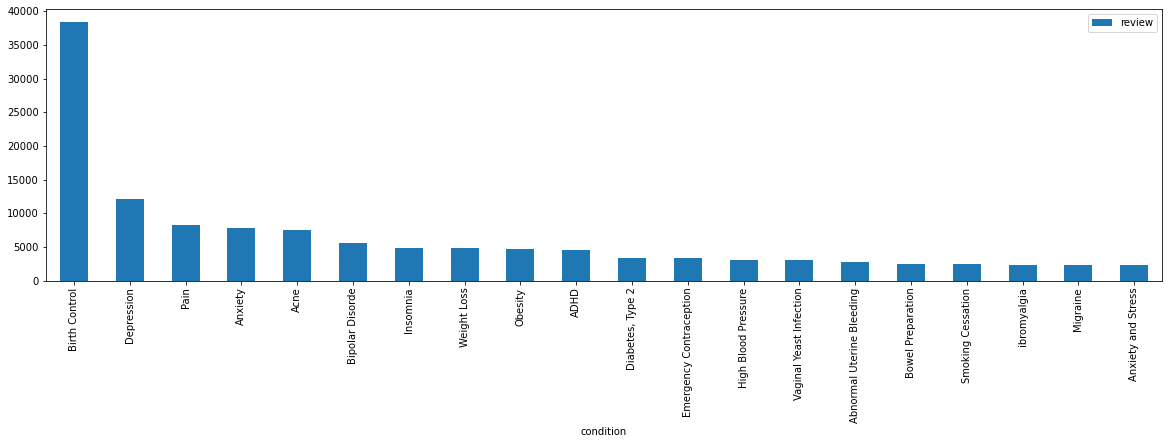

In [12]:
drugs = drugs.iloc[[idx for idx, i in enumerate(drugs.condition) if "</span>" not in i]]
drugs["review"] = list(map(lambda x : x.replace("&#039;", "").replace("&quot",""), drugs.review))
drugs.groupby("condition").count().sort_values(by="review", ascending=False)[:20].plot(kind="bar", y="review", figsize=(20,5))

Again, we notice that most of the reviews pertain to birth control.

Now looking at the distribution of ratings and usefulness counts.

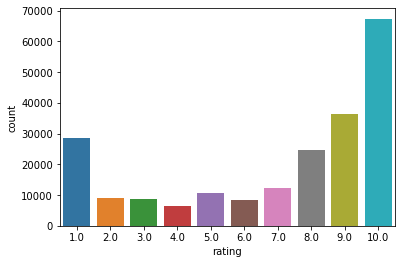

In [13]:
sns.countplot(drugs["rating"]);

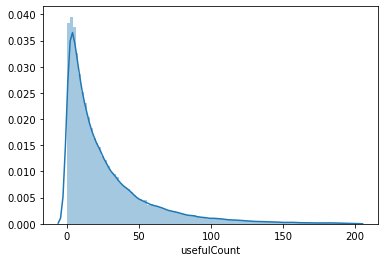

In [14]:
sns.distplot(drugs[drugs["usefulCount"] < 200].usefulCount, bins=100, kde=True)

There are a few reviews with usefulness counts close to a thousand. However, most reviews have a much lesser amount of useful counts. Using a maximum of 200 allows for a better view of the distribution.

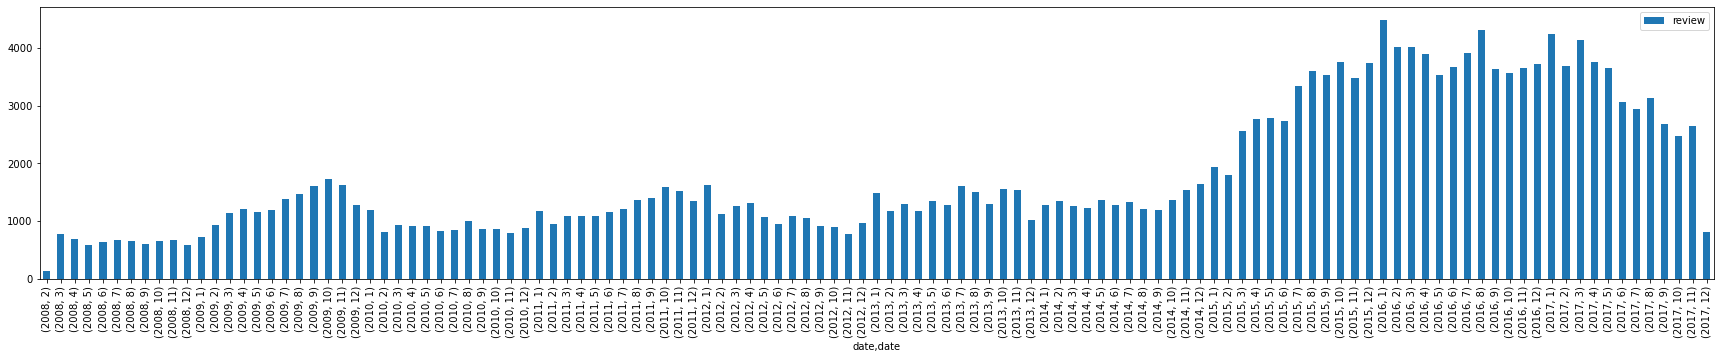

In [15]:
# Plot the number of reveiews in each month
drugs.groupby([drugs.date.dt.year, drugs.date.dt.month]).count().plot(kind="bar", y="review", figsize=(30,5));

The number of reviews was farily consistent at about 1000 reviews per month. The number increased starting the beginning of 2015 to around 3000 until 2017, when it started to decrease.

Let's see how the usefulCounts correlated with the condition.

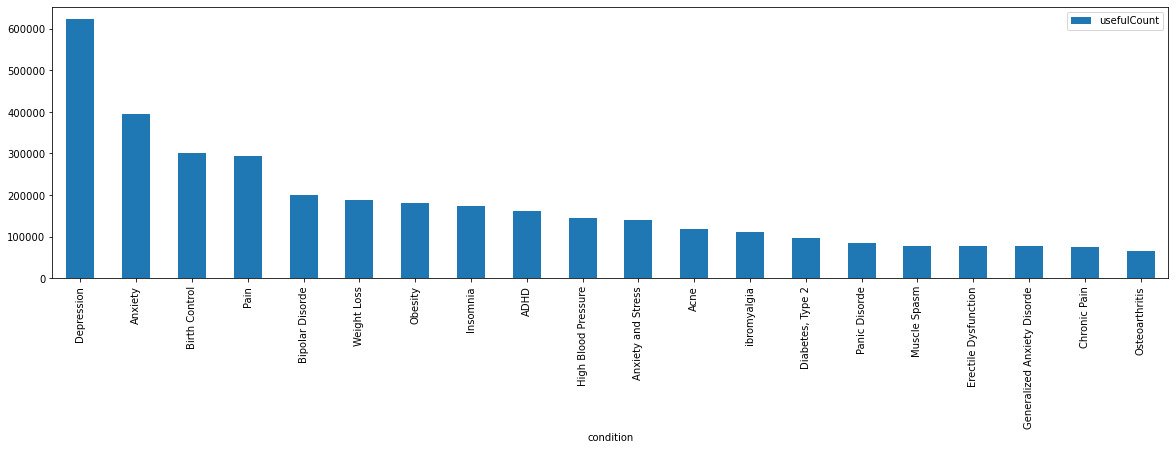

In [16]:
drugs.groupby("condition").sum().sort_values(by="usefulCount", ascending=False)[:20].plot(kind="bar", y="usefulCount", figsize=(20,5))

Looks like in this case, birth control reviews was not the overall top voted.

Here's what we know:

1. There are few missing conditions, however, this number is less than 1% of the entire data.
2. Ethinyl Estradiol and Levonorgestrel were the two most reviewed drugs. The top 4 reviewed drugs are types of birth control medicines.
3. Likewise, birth control was the most often condition of the reviews. (More than 2x that of the second most often condition)
4. Most ratings were either 1 or 8-10. Not many neutral ratings. Probably becuase people give reviews if a product performed outside of their expectation (positive or negative).
5. Usefulness counts have a ?log-normal? ?chi-squared? distribution.
6. The number of reviews was farily consistent at about 1000 reviews per month. The number increased starting the beginning of 2015 to around 3000 until 2017, when it started to decrease.
7. Birth control reviews was not the overall top voted.